# Wind Power Investigation and Modelling

***

This notebook investigates the dataset and models the data. Once a suitable model is chosen, a flask web application will be used for predictions.

In [49]:
# Imports and options
import pandas as pd
import seaborn as sns
pd.set_option('precision', 5)

In [50]:
#Load the dataset
wind = pd.read_csv('powerproduction.txt')
wind

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


### Some basic properties of the dataset

In [3]:
wind.columns

Index(['speed', 'power'], dtype='object')

In [4]:
wind.shape

(500, 2)

In [5]:
wind.isna().sum()

speed    0
power    0
dtype: int64

In [6]:
wind.isnull().sum()

speed    0
power    0
dtype: int64

In [7]:
wind.describe()

,speed,power
count,500.00000,500.00000
mean,12.59040,48.01458
std,7.22499,41.61457
min,0.00000,0.00000
25%,6.32475,5.28800
50%,12.55050,41.64550
75%,18.77525,93.53700
max,25.00000,113.55600


In [8]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


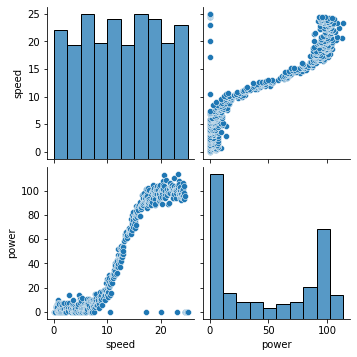

In [51]:
#Pair plot of the data using seaborn. We can see how the data is distributed.
sns.pairplot(wind);

Seems to be some outliers here. I think its reasonable to assume that if the turbine was functioning porperly, there would be power output. So I will assume that these zero values for power, were for times when the turbine was offline due to maintenance or was malfunctioning.

In [52]:
# Removing the zero power outliers
wind = wind[wind['power'] != 0.000]

In [11]:
wind.describe()

,speed,power
count,451.00000,451.00000
mean,13.00430,53.23125
std,6.83598,40.52205
min,0.32500,0.06700
25%,7.34450,8.54350
50%,13.03800,58.16800
75%,18.78150,94.72550
max,24.39900,113.55600


Plotting again to make sure data is cleaner now.

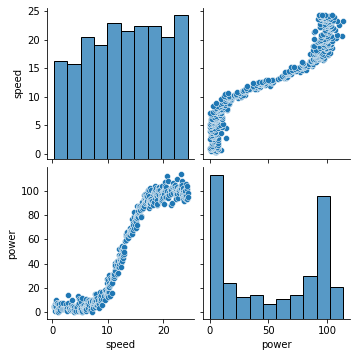

In [53]:
sns.pairplot(wind);

### Regressions on the dataset

I will start with some regressions on the dataset, to see how well the dataset can be modelled with a regression.

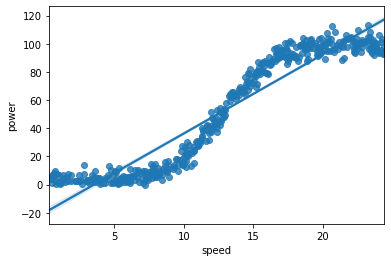

In [58]:
sns.regplot(x="speed", y="power", data=wind);

Not a great fit, but we will do the fit with sklearn anyway and analyse.

In [61]:
# do a linear regression with sklearn
import sklearn.linear_model as lin

# sklearn expects an array, so the data is converted
x = wind["speed"].to_numpy()
y = wind["power"].to_numpy()

# Array needs to be reshaped
x = x.reshape(-1, 1)

# Create the model and fit
model = lin.LinearRegression()
model.fit(x, y)

# Model score, intercept and coefficient 
r = model.score(x, y)
p = [model.intercept_, model.coef_[0]]

In [105]:
# The R-squared value for the fit. Seems quite high but we can see on the graph that the fit is not that good. [1]
r

0.8984832870534454

In [63]:
p

[-19.837685452108396, 5.618827837778541]

In [65]:
# A function to predict
def f(x, p):
    return p[0] + x * p[1]

In [66]:
f(13,p)

53.207076439012646

In [67]:
# Simpler way to predict using above function
def predict(x):
    return f(x,p)

In [68]:
predict(13)

53.207076439012646

***
Now I will do some more regression using numpy.

In [70]:
# import numpy and pyplot
import numpy as np
import matplotlib.pyplot as plt

In [71]:
x = wind["speed"].to_numpy()
y = wind["power"].to_numpy()

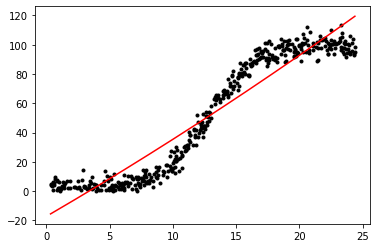

In [72]:
# Numpy polynomial fit
a,b,c = np.polyfit(x,y,2)
# plot original data and the quadatic polyfit
plt.plot(x, y, 'k.')
plt.plot(x, a * x * x + b * x  +  c , 'r-');

As we can see, a similar fit to the linear regression.

In [73]:
# A numpy polynomial fit
a, b, c , d = np.polyfit(x, y, 3)

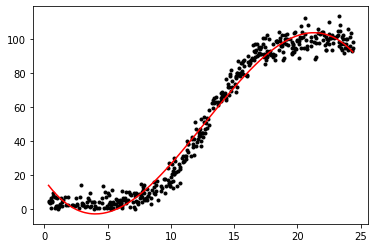

In [74]:
# Plot the original and fitted data
plt.plot(x, y, 'k.')
plt.plot(x, a * x * x * x + b * x *x  +  c * x + d, 'r-');

The residuals is sum of squared residuals of the least-squares fit. We can use this to get the man squared loss for later comparison with neural network with mean squared loss.[[2]](#References)

In [84]:
# Get the fit residuals
#adatpted from  https://stackoverflow.com/questions/15721053/whats-the-error-of-numpy-polyfit
_,res,_,_,_ = np.polyfit(x, y, 3,full=True)
res

array([16018.47640311])

Get the mean squared loss (residuals divided by number or data points)

In [87]:
msl = res/len(x)
print(f"Mean Squared Loss is {msl[0]}.")

Mean Squared Loss is 35.517686037946305.


***

Modelling using Tensorflow Neural Networks

In [88]:
# Import Keras
import tensorflow.keras as kr

In [89]:
# A sequential model
model = kr.models.Sequential()

In [90]:
# Add two layers and compile. I tried variations on all these parameters but most of them made no difference and some of them had a negative effect on the fit.
model.add(kr.layers.Dense(10, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile('adam', loss='mean_squared_error')

In [91]:
# Fit the model with 500 epochs in batches of 10
model.fit(x, y, epochs=500, batch_size=10)

Epoch 1/500
46/46 [==============================] - 0s 4ms/step - loss: 4730.0977
Epoch 2/500
46/46 [==============================] - 0s 3ms/step - loss: 4689.5996
Epoch 3/500
46/46 [==============================] - 0s 4ms/step - loss: 4642.0049
Epoch 4/500
46/46 [==============================] - 0s 4ms/step - loss: 4592.2153
Epoch 5/500
46/46 [==============================] - 0s 3ms/step - loss: 4531.1992
Epoch 6/500
46/46 [==============================] - 0s 4ms/step - loss: 4472.4531
Epoch 7/500
46/46 [==============================] - 0s 4ms/step - loss: 4427.0449
Epoch 8/500
46/46 [==============================] - 0s 3ms/step - loss: 4389.9912
Epoch 9/500
46/46 [==============================] - 0s 3ms/step - loss: 4350.1191
Epoch 10/500
46/46 [==============================] - 0s 4ms/step - loss: 4314.6650
Epoch 11/500
46/46 [==============================] - 0s 3ms/step - loss: 4283.1265
Epoch 12/500
46/46 [==============================] - 0s 4ms/step - loss: 4253.7812
E

Plot of the actual data and the predicted data.

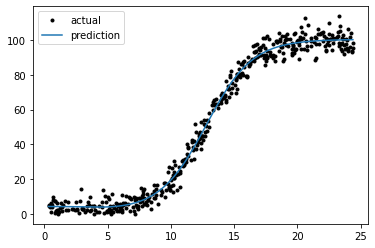

In [93]:
plt.plot(x, y,'k.', label='actual')
plt.plot(x, model.predict(x), label='prediction')
plt.legend();

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


A quick prediction.

In [95]:
model.predict(np.array([15]))

array([[77.626785]], dtype=float32)

Get the loss value (Meas Squared Loss). [[3]](#References)

In [97]:
mean_sq_loss = model.evaluate(x, y)
print(f"Mean Squared Loss is {mean_sq_loss}.")

15/15 [==============================] - 0s 2ms/step - loss: 16.5615
Mean Squared Loss is 16.561542510986328.


***
The model is saved in a h5 file format. The model can then be loaded in the flask web application as opposed to running the fit again.

In [98]:
model.save_weights("wind_power_weights.h5")
model.save('wind_power.h5')

Load the model from the h5 file to make sure it is correct.

In [99]:
from tensorflow.keras.models import load_model
new_model = load_model('wind_power.h5')

In [100]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [103]:
score = new_model.evaluate(x, y,)
print(f"Mean Squared Loss is {score}.")
score == mean_sq_loss

15/15 [==============================] - 0s 2ms/step - loss: 16.5615
Mean Squared Loss is 16.561542510986328.


True

In [104]:
new_model.predict([15])

array([[77.626785]], dtype=float32)

## Summary

The dataset was loaded and explored. It was concluded that there were outliers in the data and these were removed. The dataset was modelled with linear and polynomial fits and finally with a tensorflow neural network.

As is visible in the plots above , the neural network has provided the best fit and the linear regression the worst fit.

While the polynomial fit closely resembles the dataset, there are aspects of the fit that are not good. The lower half for example has clear gaps between the data and the fit.

Clearly the neural network has visually the best fit, but more importantly this is borne out in the loss for the fit. The mean squared loss for the neural network is 16.56 as compared to 35.5 for the polyfit.

This is why I have chosen the neural network for the web application.

## References

[1] [Numpy Polyfit documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), accessed online, December 2020.

[2] [What's the error of numpy.polyfit?](https://stackoverflow.com/questions/15721053/whats-the-error-of-numpy-polyfit), accessed online, December 2020.

[3] [TensorFlow, Training and Evalutaion with built in methods](https://www.tensorflow.org/guide/keras/train_and_evaluate), accessed online, December 2020.

[4] Brownlee, Jason. [How to Configure the Number of Layers and Nodes in a Neural Network](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/) , accessed online, December 2020.

[5] Brownlee, Jason. [How to Choose Loss Functions When Training Deep Learning Neural Networks](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) , accessed online, December 2020.

[6] Brownlee, Jason. [Your First Deep Learning Project in Python with Keras Step-By-Step](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/) , accessed online, December 2020.

[7] Brownlee, Jason. [How to Save and Load Your Keras Deep Learning Model](https://machinelearningmastery.com/save-load-keras-deep-learning-models/) , accessed online, December 2020.

[8] [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize#weights_only_saving_in_savedmodel_format), accessed online, December 2020.

[9] [How to improve performance of Neural Networks](https://d4datascience.wordpress.com/2016/09/29/fbf/) , accessed online, December 2020.

[10] [Improving the Performance of a Neural Network](https://towardsdatascience.com/how-to-increase-the-accuracy-of-a-neural-network-9f5d1c6f407d) , accessed online, December 2020.
